Installations

In [2]:
# Check Colab virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
55M	/content/sample_data
55M	/content


In [3]:
# Upgrade pip
!pip install --upgrade pip

# Install PyTorch/XLA for TPU
!pip install torch torchvision torchaudio
# torch_xla --extra-index-url https://storage.googleapis.com/pytorch-tpu-releases/wheels/tpuvm/torch_xla-2.8
# Upgrade Hugging Face and other dependencies
!pip install --upgrade diffusers transformers accelerate safetensors datasets huggingface_hub peft opencv-python-headless python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 42.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 124.5 MB/s  0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [datasets]


In [4]:
# Verify diffusers version
import diffusers
print(diffusers.__version__)

0.35.2


Libraries

In [5]:
import torch
# Colorizer-------------------
from diffusers import StableDiffusionPipeline
# Inpainting ---------------
from diffusers import StableDiffusionInpaintPipeline
# ----------------------------------------
from google.colab import drive
import os
from dotenv import load_dotenv
from datasets import load_dataset
from huggingface_hub import login

# Preprocessing, data handling
from sklearn.model_selection import train_test_split

# Visualizations
import cv2
from PIL import Image, ImageDraw
from IPython.display import display
import matplotlib.pyplot as plt

# Colorizer fine tuning
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model_state_dict
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import LoraConfig, get_peft_model_state_dict, get_peft_model
from torch import nn, optim
from tqdm import tqdm

# LoRA prep
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
from diffusers import StableDiffusionPipeline
import contextlib, io
# Performance
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim




In [6]:
# Check virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
55M	/content/sample_data
55M	/content


In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Env file path
env_path = "/content/drive/MyDrive/AAI-521 Final Project/hf_login.env"
# Open env file
load_dotenv(env_path)
# Access token from environment
hf_key = os.getenv("HF_TOKEN")
print("HF key loaded:", hf_key is not None)

# Dataset Paths

# Paths for colorization ds train/val/test img subsets
COLORIZER_DATA_ROOT = "/content/drive/MyDrive/AAI-521 Final Project/colorization_subset"
COLOR_SPLIT_DIRS = {
    "train": os.path.join(COLORIZER_DATA_ROOT, "train"),
    "val":   os.path.join(COLORIZER_DATA_ROOT, "val"),
    "test":  os.path.join(COLORIZER_DATA_ROOT, "test"),
}
# Create dataset directories
os.makedirs(COLORIZER_DATA_ROOT, exist_ok=True)
for d in COLOR_SPLIT_DIRS.values():
    os.makedirs(d, exist_ok=True)
    os.makedirs(os.path.join(d, "gray"), exist_ok=True)
    os.makedirs(os.path.join(d, "color"), exist_ok=True)

COLORIZER_MODEL_OUTPUT = "/content/drive/MyDrive/AAI-521 Final Project/fine_tuned_models"
# Path to colorizer test image
colorize_image_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/colorize_ex1.png"
# Ensure test_images folder exists
os.makedirs("/content/drive/MyDrive/AAI-521 Final Project/test_images", exist_ok=True)

IMG_SIZE = (512, 512)   # Resolution must be divisible by 8 (SD requirement)



FINE_MODEL_SAVE_DIR = "/content/drive/MyDrive/AAI-521 Final Project/fine_tuned_models"
# Make sure it exists
os.makedirs(FINE_MODEL_SAVE_DIR, exist_ok=True)

# ------------------------------------------
# Colorizer - Model and Pipe Paths
# ------------------------------------------

COLORIZER_SAVE_DIR = os.path.join(FINE_MODEL_SAVE_DIR, "colorizer")
os.makedirs(COLORIZER_SAVE_DIR, exist_ok=True)


# Subfolder for pipeline
FINE_PIPELINE_DIR = os.path.join(COLORIZER_MODEL_OUTPUT, "colorizer_pipeline")
os.makedirs(FINE_PIPELINE_DIR, exist_ok=True)

# ------------------------------------------
# Inpainting - Dataset Paths
# ------------------------------------------
INPAINT_DATA_ROOT = "/content/drive/MyDrive/AAI-521 Final Project/inpainting_subset"
INPAINT_SPLIT_DIRS = {
    "train": os.path.join(INPAINT_DATA_ROOT, "train"),
    "val":   os.path.join(INPAINT_DATA_ROOT, "val"),
    "test":  os.path.join(INPAINT_DATA_ROOT, "test"),
}

# Create folders
os.makedirs(INPAINT_DATA_ROOT, exist_ok=True)
for d in INPAINT_SPLIT_DIRS.values():
    os.makedirs(d, exist_ok=True)
    os.makedirs(os.path.join(d, "masked"), exist_ok=True)
    os.makedirs(os.path.join(d, "original"), exist_ok=True)


# Ensure test_images folder exists
os.makedirs("/content/drive/MyDrive/AAI-521 Final Project/test_images", exist_ok=True)

inpaint_image_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/inpaint_ex1.png"

# ------------------------------------------
# Inpainting - Model and Pipe Paths
# ------------------------------------------

# Updated - use inpainting subfolder
INPAINT_SAVE_DIR = os.path.join(FINE_MODEL_SAVE_DIR, "inpainting")
os.makedirs(INPAINT_SAVE_DIR, exist_ok=True)

# Subfolder for pipeline
INPAINT_PIPELINE_DIR = os.path.join(INPAINT_SAVE_DIR, "inpainting_pipeline")
os.makedirs(FINE_PIPELINE_DIR, exist_ok=True)


HF key loaded: True


In [ ]:

# Check virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
11G	/content/drive
55M	/content/sample_data
11G	/content


In [ ]:
colorize_test_image = Image.open(colorize_image_path).convert("RGB")

Load COCO dataset

In [ ]:
coco_ds = load_dataset("detection-datasets/coco")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00040-67e35002d15215(…):   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00001-of-00040-2c2b33b9504aa8(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00002-of-00040-58e30306870b1d(…):   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00003-of-00040-a77e00648e4239(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00004-of-00040-1df1755d6f7c9b(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00005-of-00040-29ccfc8f52cfc9(…):   0%|          | 0.00/473M [00:00<?, ?B/s]

data/train-00006-of-00040-76f2d663d51dca(…):   0%|          | 0.00/483M [00:00<?, ?B/s]

data/train-00007-of-00040-797508421c59b9(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00008-of-00040-7ad10a6d6b442e(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00009-of-00040-edc6018bb7abee(…):   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00010-of-00040-068d922af9742c(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00011-of-00040-2cf010e9592da4(…):   0%|          | 0.00/483M [00:00<?, ?B/s]

data/train-00012-of-00040-e26d7a054b1f8c(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00013-of-00040-00a967ab3e2568(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00014-of-00040-4f6a348405f372(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00015-of-00040-ae8972f628750c(…):   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00016-of-00040-37711297359438(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00017-of-00040-e2f542f29ca613(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00018-of-00040-3650ae2c12a832(…):   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00019-of-00040-f262669c6302eb(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00020-of-00040-d2763ce5e7ab09(…):   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00021-of-00040-fb98d35ab4e6ca(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00022-of-00040-c4f90a7435af52(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00023-of-00040-31db5fa16e24d3(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00024-of-00040-786ee9123ad04e(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00025-of-00040-369c096f8c7d7a(…):   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00026-of-00040-709cf1a409a269(…):   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00027-of-00040-c99041dbf75151(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00028-of-00040-5e11f3d596cb0d(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00029-of-00040-988997614786b5(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00030-of-00040-497df2d4082da4(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00031-of-00040-541a6ccf9f2109(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00032-of-00040-659aee4f72e8f5(…):   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00033-of-00040-0074f368f67338(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00034-of-00040-edcd109018ecaf(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00035-of-00040-c8fd4fb1bb9311(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00036-of-00040-5d6d294fbed2af(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00037-of-00040-cb1276b8824445(…):   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00038-of-00040-15a5fd14791741(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00039-of-00040-f1a97fa690638b(…):   0%|          | 0.00/474M [00:00<?, ?B/s]

data/val-00000-of-00002-c4f2e391ee4aba11(…):   0%|          | 0.00/404M [00:00<?, ?B/s]

data/val-00001-of-00002-7af5414a3b178949(…):   0%|          | 0.00/404M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/117266 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/4952 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Full COCO dataset
coco_ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 117266
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 4952
    })
})

In [ ]:
# Check Colab virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
11G	/content/drive
55M	/content/sample_data
11G	/content


# Filter COCO ds for 1500 color images

In [ ]:
# Confirm color
def is_color(pil_img):
    if pil_img.mode != "RGB":
        return False
    r, g, b = pil_img.split()
    return not (r == g == b)

color_images = []
max_needed = 1500

# Only use existing splits: train and val
for split in ["train", "val"]:
    for row in coco_ds[split]:

        img = row["image"]  # already a PIL image

        try:
            img = img.convert("RGB")
        except:
            continue

        if not is_color(img):
            continue

        color_images.append(img)

        if len(color_images) >= max_needed:
            break

    if len(color_images) >= max_needed:
        break

len(color_images)

1500

# Create Mask Pairs

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import random

def apply_rectangle_mask(img, max_area_frac=0.25, max_rects=3):
    w, h = img.size
    mask = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask)

    for _ in range(random.randint(1, max_rects)):
        area = random.uniform(0.02, max_area_frac)
        rect_w = int(w * (area ** 0.5) * random.uniform(0.5, 1.5))
        rect_h = int(h * (area ** 0.5) * random.uniform(0.5, 1.5))

        x1 = random.randint(0, max(0, w - rect_w))
        y1 = random.randint(0, max(0, h - rect_h))

        draw.rectangle([x1, y1, x1 + rect_w, y1 + rect_h], fill=255)

    # apply mask
    masked = img.copy()
    arr = np.array(masked)
    mask_np = np.array(mask)
    arr[mask_np == 255] = 0  # black masked pixels

    return Image.fromarray(arr), mask

# -----------------------------------------
# Create (masked_img, original_img) pairs
# -----------------------------------------
pairs = []

for img in color_images:
    original = img.resize(IMG_SIZE, resample=Image.LANCZOS)

    masked, _ = apply_rectangle_mask(original)

    pairs.append((masked, original))

print(len(pairs))
print('Splitting datasets for train, val, test...')

train_pairs, temp_pairs = train_test_split(pairs, test_size=0.30, random_state=42)
val_pairs, test_pairs   = train_test_split(temp_pairs, test_size=0.50, random_state=42)

print(f"Dataset images count (train/val/test): {len(train_pairs), len(val_pairs), len(test_pairs)}")

# -----------------------------------------
# Save images
# -----------------------------------------
print('Saving images (train/val/test)...')

for split_name, split_pairs in [
    ("train", train_pairs),
    ("val", val_pairs),
    ("test", test_pairs),
]:
    out_dir = INPAINT_SPLIT_DIRS[split_name]

    masked_dir = os.path.join(out_dir, "masked")
    orig_dir   = os.path.join(out_dir, "original")

    os.makedirs(masked_dir, exist_ok=True)
    os.makedirs(orig_dir, exist_ok=True)

    for i, (masked_img, original_img) in enumerate(split_pairs):
        masked_img.save(os.path.join(masked_dir, f"{i:05d}.png"))
        original_img.save(os.path.join(orig_dir, f"{i:05d}.png"))


1500
Splitting datasets for train, val, test...
Dataset images count (train/val/test): (1050, 225, 225)
Saving images (train/val/test)...


# Visualize mask pairs

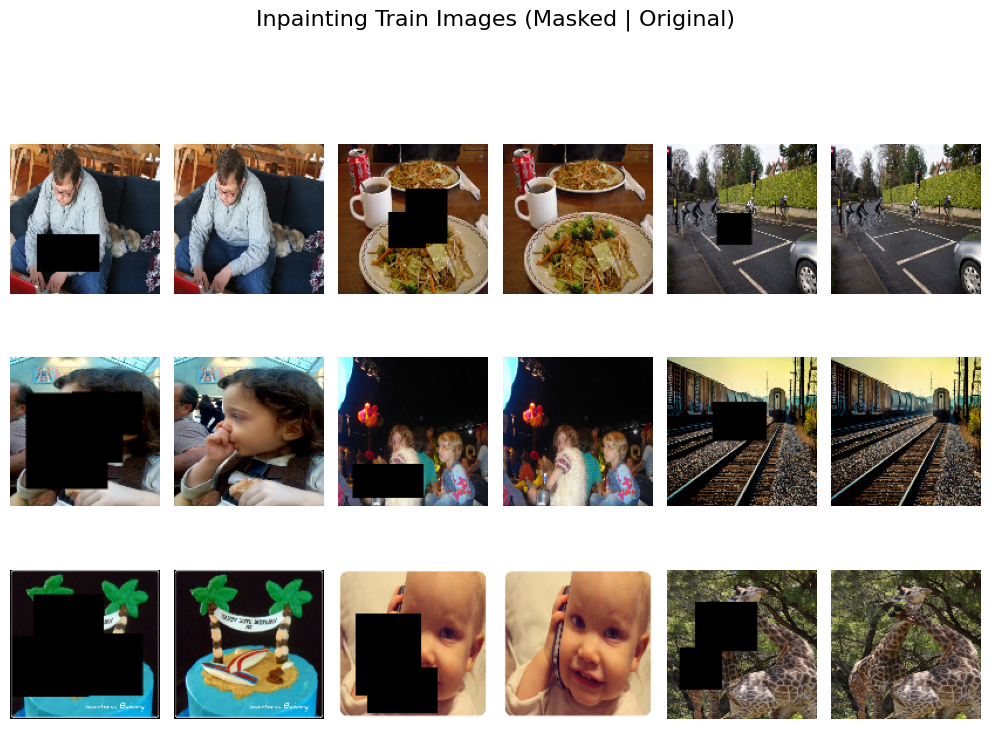

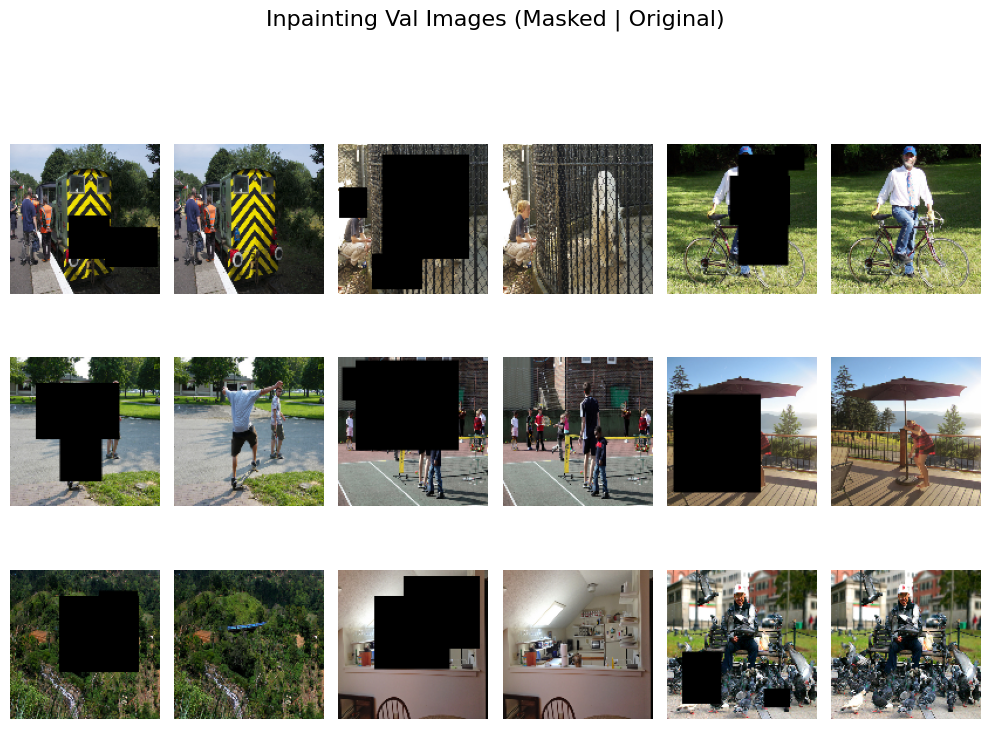

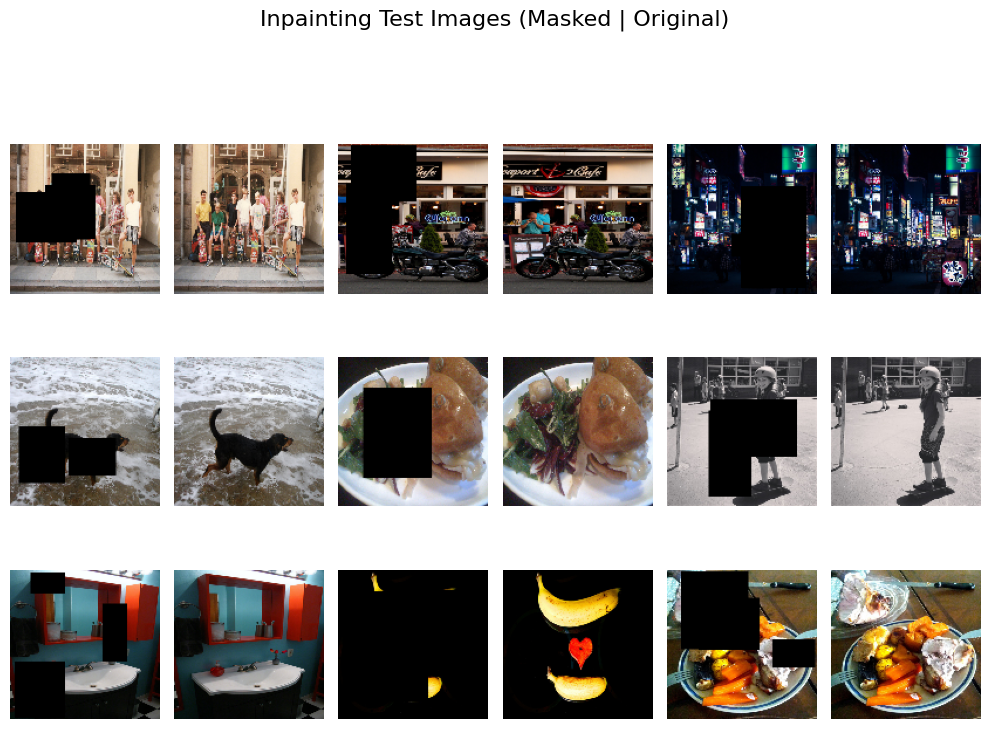

In [10]:
splits = ["train", "val", "test"]

for split_name in splits:
    masked_dir = os.path.join(INPAINT_SPLIT_DIRS[split_name], "masked")
    orig_dir   = os.path.join(INPAINT_SPLIT_DIRS[split_name], "original")

    # First 9 images
    image_files = sorted(os.listdir(orig_dir))[:9]

    # Load & resize
    masked_images = [
        cv2.resize(cv2.imread(os.path.join(masked_dir, f)), (128,128))
        for f in image_files
    ]
    orig_images = [
        cv2.resize(cv2.imread(os.path.join(orig_dir, f)), (128,128))
        for f in image_files
    ]

    # Plot
    plt.figure(figsize=(10, 8))
    plt.suptitle(f"Inpainting {split_name.capitalize()} Images (Masked | Original)", fontsize=16)

    for i in range(9):
        # Masked image
        plt.subplot(3, 6, 2*i+1)
        plt.imshow(cv2.cvtColor(masked_images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Original
        plt.subplot(3, 6, 2*i+2)
        plt.imshow(cv2.cvtColor(orig_images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [11]:
# Check Colab virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
12G	/content/drive
55M	/content/sample_data
12G	/content


# Inpainting Fine tuning preparation and Prepare Unet for LoRA

In [17]:
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
from torchvision import transforms as T

# Transform for masked/original images
img_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)  # scale to [-1,1] for Stable Diffusion
])

# Transform for masks
mask_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()  # will convert 0/255 to 0.0/1.0
])

class InpaintingDataset(Dataset):
    def __init__(self, masked_dir, orig_dir, transform=None, mask_transform=None):
        self.masked_files = sorted(os.listdir(masked_dir))
        self.orig_files   = sorted(os.listdir(orig_dir))
        self.masked_dir = masked_dir
        self.orig_dir   = orig_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.masked_files)

    def __getitem__(self, idx):
        masked = Image.open(os.path.join(self.masked_dir, self.masked_files[idx])).convert("RGB")
        orig   = Image.open(os.path.join(self.orig_dir,   self.orig_files[idx])).convert("RGB")

        # auto-build binary mask from black pixels
        masked_np = np.array(masked)
        mask_np = (masked_np.sum(axis=2) == 0).astype(np.uint8)  # shape H,W

        mask_img = Image.fromarray(mask_np * 255)  # convert to PIL for transform

        if self.transform:
            masked = self.transform(masked)
            orig   = self.transform(orig)

        if self.mask_transform:
            mask = self.mask_transform(mask_img)
        else:
            mask = T.ToTensor()(mask_img)

        return {
            "masked": masked,    # 3×512×512
            "mask":   mask,      # 1×512×512 (0 or 1)
            "orig":   orig       # 3×512×512
        }
train_dataset = InpaintingDataset(
    os.path.join(INPAINT_DATA_ROOT, "train", "masked"),
    os.path.join(INPAINT_DATA_ROOT, "train", "original"),
    transform=img_transform,
    mask_transform=mask_transform
)

val_dataset = InpaintingDataset(
    os.path.join(INPAINT_DATA_ROOT, "val", "masked"),
    os.path.join(INPAINT_DATA_ROOT, "val", "original"),
    transform=img_transform,
    mask_transform=mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2)

from diffusers import (
    StableDiffusionInpaintPipeline,
    UNet2DConditionModel,
    AutoencoderKL,
    PNDMScheduler,
)
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model

# ---------------------------------------------
# Base inpainting model name
# ---------------------------------------------
inpaint_base_model = "runwayml/stable-diffusion-inpainting"

# ---------------------------------------------
# Load components manually (UNET / VAE / Text Encoder)
# ---------------------------------------------
unet = UNet2DConditionModel.from_pretrained(inpaint_base_model, subfolder="unet")
vae = AutoencoderKL.from_pretrained(inpaint_base_model, subfolder="vae")
text_encoder = CLIPTextModel.from_pretrained(inpaint_base_model, subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained(inpaint_base_model, subfolder="tokenizer")
scheduler = PNDMScheduler.from_pretrained(inpaint_base_model, subfolder="scheduler")

# ---------------------------------------------
# Build the inpainting pipeline (no safety checker)
# ---------------------------------------------
inpaint_pipe = StableDiffusionInpaintPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None,
)

# ---------------------------------------------
# LoRA configuration for UNet attention layers
# ---------------------------------------------
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    init_lora_weights="gaussian"
)

# ---------------------------------------------
# Inject LoRA layers into the UNet
# ---------------------------------------------
inpaint_pipe.unet = get_peft_model(inpaint_pipe.unet, lora_config)

# ---------------------------------------------
# Verify trainable parameters
# ---------------------------------------------
inpaint_pipe.unet.print_trainable_parameters()
print("Inpainting UNet is LoRA-ready.")


An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all

trainable params: 1,594,368 || all params: 861,129,732 || trainable%: 0.1851
Inpainting UNet is LoRA-ready.


In [13]:
# Check Colab virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
12G	/content/drive
55M	/content/sample_data
12G	/content


In [14]:
# Load pre-trained inpainting model pipeline
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting"
)

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [15]:
# Check Colab virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
12G	/content/drive
55M	/content/sample_data
12G	/content


# Fine tune inpainting model pipe with LoRA
- feeding the masked image
- + mask tensor
- +  text prompt into the UNet "inpaint the masked area of the image"

In [ ]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
unet = inpaint_pipe.unet.to(device)
vae = inpaint_pipe.vae.to(device)

unet.train()
vae.eval()

optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Accuracy metric
def latent_accuracy(pred, target, threshold=0.01):
    mse_per_pixel = ((pred - target) ** 2).mean(dim=(1,2,3))
    return (mse_per_pixel < threshold).float().mean().item()

# Early stopping
patience = 2
bad_epochs = 0
best_val_loss = float("inf")

BEST_MODEL_PATH = os.path.join(FINE_MODEL_SAVE_DIR, "inpainting", "best_unet")
BEST_PIPELINE_PATH = os.path.join(FINE_MODEL_SAVE_DIR, "inpainting", "inpainting_pipeline")
os.makedirs(BEST_MODEL_PATH, exist_ok=True)
os.makedirs(BEST_PIPELINE_PATH, exist_ok=True)

for epoch in range(num_epochs):
    unet.train()

    train_loss = 0
    train_acc = 0

    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):

        masked = batch["masked"].to(device)
        mask = batch["mask"].to(device)
        orig = batch["orig"].to(device)
        B = masked.size(0)

        optimizer.zero_grad()

        # Encode latents
        with torch.no_grad():
            masked_latent = vae.encode(masked / 255.0).latent_dist.sample() * 0.18215
            orig_latent = vae.encode(orig / 255.0).latent_dist.sample() * 0.18215

        # Prompt handling (if needed)
        encoder_hidden_states = None
        if hasattr(inpaint_pipe, "text_encoder"):
            prompt = ["restore missing region"] * B
            ids = inpaint_pipe.tokenizer(
                prompt, return_tensors="pt", padding="max_length", truncation=True
            ).input_ids.to(device)
            with torch.no_grad():
                encoder_hidden_states = inpaint_pipe.text_encoder(ids)[0]

        timestep = torch.tensor([1] * B, device=device)

        mask_latent = torch.nn.functional.interpolate(mask, size=masked_latent.shape[-2:])
        mask_latent = mask_latent.repeat(1, 5, 1, 1)  # expand to 5 channels
        latent_input = torch.cat([masked_latent, mask_latent], dim=1)  # 4 + 5 = 9 channels

        pred_latent = unet(
            latent_input,
            timestep=timestep,
            encoder_hidden_states=encoder_hidden_states
        ).sample

        loss = criterion(pred_latent, orig_latent)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * B
        train_acc += latent_accuracy(pred_latent, orig_latent) * B

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # -------- VALIDATION ----------
    unet.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for batch in val_loader:
            masked = batch["masked"].to(device)
            mask = batch["mask"].to(device)
            orig = batch["orig"].to(device)
            B = masked.size(0)

            masked_latent = vae.encode(masked / 255.0).latent_dist.sample() * 0.18215
            orig_latent = vae.encode(orig / 255.0).latent_dist.sample() * 0.18215

            encoder_hidden_states = None
            if hasattr(inpaint_pipe, "text_encoder"):
                ids = inpaint_pipe.tokenizer(
                    ["restore missing region"] * B,
                    return_tensors="pt",
                    padding="max_length",
                    truncation=True
                ).input_ids.to(device)
                encoder_hidden_states = inpaint_pipe.text_encoder(ids)[0]

            timestep = torch.tensor([1] * B, device=device)

            mask_latent = torch.nn.functional.interpolate(mask, size=masked_latent.shape[-2:])
            mask_latent = mask_latent.repeat(1, 5, 1, 1)  # expand to 5 channels
            latent_input = torch.cat([masked_latent, mask_latent], dim=1)  # 4 + 5 = 9 channels

            pred_latent = unet(
                latent_input,
                timestep=timestep,
                encoder_hidden_states=encoder_hidden_states
            ).sample

            val_loss += criterion(pred_latent, orig_latent).item() * B
            val_acc += latent_accuracy(pred_latent, orig_latent) * B

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} → "
          f"Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f} | "
          f"Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

    # ------- Non verbose model saving -------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        bad_epochs = 0

        inpaint_pipe.unet.save_pretrained(BEST_MODEL_PATH, safe_serialization=True)
        inpaint_pipe.save_pretrained(BEST_PIPELINE_PATH)

        print("Saved best model (silent).")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping.")
            break

# -------- PLOTS --------
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs, marker='o', label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.show()


Train Epoch 1:   3%|▎         | 14/525 [08:43<5:16:53, 37.21s/it]

Test image with fine tuned model

In [ ]:
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline
import torch
import os

# --- Load your fine-tuned inpainting pipeline ---

ft_inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
"/content/drive/MyDrive/AAI-521 Final Project/fine_tuned_models/inpainting_pipeline",
torch_dtype=torch.float16
).to("cuda")

ft_inpaint_pipe.unet.eval()
ft_inpaint_pipe.vae.eval()

# --- Load the test image and optional mask ---

image_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/inpaint_ex1.png"
image = Image.open(image_path).convert("RGB")

# Optional: provide a mask image (white=keep, black=fill). If None, use a fully masked region

mask_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/inpaint_ex1_mask.png"
mask = Image.open(mask_path).convert("L") if os.path.exists(mask_path) else None

# --- Run inpainting ---

output = ft_inpaint_pipe(
prompt="restore missing regions",
image=image,
mask_image=mask,        # can be None
strength=0.75,          # 0 = keep original, 1 = mostly generated
guidance_scale=5,       # how strongly model follows prompt
num_inference_steps=70
).images[0]

# --- Display and save ---

display(output)
output.save("/content/drive/MyDrive/AAI-521 Final Project/test_images/output_inpaint_demo.png")


--- Load test images ---

--- Prepare pipeline ---
--- Run inpainting ---
--- Display results ---


In [ ]:


test_files = sorted(os.listdir(TEST_MASKED_DIR))[:9] # first 9
masked_images = [Image.open(os.path.join(TEST_MASKED_DIR, f)).convert("RGB") for f in test_files]
orig_images = [Image.open(os.path.join(TEST_ORIG_DIR, f)).convert("RGB") for f in test_files]



pipe = StableDiffusionInpaintPipeline.from_pretrained(
BEST_PIPELINE_PATH,
torch_dtype=torch.float16
).to("cuda")

pipe.unet.eval()
pipe.vae.eval()



predicted_images = []
for masked in masked_images:
masked_tensor = img_transform(masked).unsqueeze(0).to("cuda")
# auto-build mask from black pixels
mask_np = (np.array(masked).sum(axis=2) == 0).astype(np.uint8)
mask_img = Image.fromarray(mask_np * 255)
mask_tensor = mask_transform(mask_img).unsqueeze(0).to("cuda")

# Encode latents
with torch.no_grad():
    masked_latent = pipe.vae.encode(masked_tensor / 255.0).latent_dist.sample() * 0.18215
    timestep = torch.tensor([1], device="cuda")
    encoder_hidden_states = None
    if hasattr(pipe, "text_encoder"):
        ids = pipe.tokenizer(["restore missing region"], return_tensors="pt", padding="max_length", truncation=True).input_ids.to("cuda")
        encoder_hidden_states = pipe.text_encoder(ids)[0]

    mask_latent = torch.nn.functional.interpolate(mask_tensor, size=masked_latent.shape[-2:])
    mask_latent = mask_latent.repeat(1, 5, 1, 1)  # 4+5=9 channels
    latent_input = torch.cat([masked_latent, mask_latent], dim=1)

    pred_latent = pipe.unet(latent_input, timestep=timestep, encoder_hidden_states=encoder_hidden_states).sample
    pred_img = pipe.vae.decode(pred_latent / 0.18215).sample
    pred_img = ((pred_img.clamp(-1,1) + 1) * 127.5).cpu().permute(0,2,3,1).numpy().astype("uint8")[0]
    predicted_images.append(Image.fromarray(pred_img))

plt.figure(figsize=(12,8))
for i in range(len(predicted_images)):
plt.subplot(3,3,i+1)
plt.imshow(predicted_images[i])
plt.axis("off")
plt.suptitle("Inpainted Results")
plt.show()